### Organisation industrielle Hiver 2024 Projet1









In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import gdown
import gspread
import pandas as pd
!pip install linearmodels
from linearmodels import OLS

### 1. Production de pétrole pour les États-Unis, la Russie et l'Arabie Saoudite

In [ ]:
from google.colab import files
# Open the following files :
# - "byd.csv"
# - "coffee_data.csv"
# - "US Tesla Car Prices - Sheet1.csv"
# - "oil-production-by-country.csv"
# Sélectionnez le fichier à télécharger
uploaded = files.upload()

Saving byd.csv to byd (1).csv
Saving coffee_data.csv to coffee_data (1).csv
Saving US Tesla Car Prices - Sheet1.csv to US Tesla Car Prices - Sheet1 (1).csv
Saving oil-production-by-country.csv to oil-production-by-country (1).csv


In [ ]:
df = pd.read_csv('oil-production-by-country.csv')
# Keep data of the past 50 years
selected_countires = ['United States', 'Russia', 'Saudi Arabia']
threshold_year = 2022 - 50
filtered_df = df[(df['Year'] >= threshold_year) & (df['Entity'].isin(selected_countires))]
filtered_df.head()

,Entity,Code,Year,Oil production (TWh)
13540,Russia,RUS,1985,6307.0190
13541,Russia,RUS,1986,6526.5470
13542,Russia,RUS,1987,6623.0645
13543,Russia,RUS,1988,6614.9000
13544,Russia,RUS,1989,6422.3887


In [ ]:
ts_df = filtered_df.pivot(index='Year', columns='Entity', values='Oil production (TWh)')
print(ts_df)

Entity     Russia  Saudi Arabia  United States
Year                                          
1972          NaN     3538.2239      6139.3360
1973          NaN     4466.0900      5985.4062
1974          NaN     4996.7960      5715.0557
1975          NaN     4179.0890      5463.4300
1976          NaN     5085.3410      5326.3057
1977          NaN     5447.4460      5382.4077
1978          NaN     4936.2310      5631.3120
1979          NaN     5675.5664      5547.4090
1980          NaN     5929.0127      5584.6494
1981          NaN     5888.8190      5568.4060
1982          NaN     3956.3428      5590.8115
1983          NaN     2794.4504      5616.8555
1984          NaN     2547.3987      5770.0690
1985    6307.0190     2001.2020      5799.9410
1986    6526.5470     2937.7393      5609.4917
1987    6623.0645     2484.2625      5434.2373
1988    6614.9000     3178.5789      5338.8906
1989    6422.3887     3153.7424      4989.6550
1990    5999.8125     3984.9460      4845.2590
1991    5372.

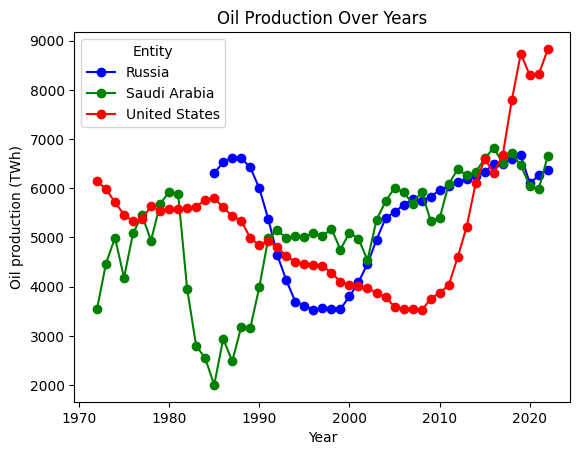

In [ ]:
ts_df.plot.line(style=['-ob', '-og', '-or'])
plt.xlabel('Year')
plt.ylabel('Oil production (TWh)')
plt.title('Oil Production Over Years')
plt.show()

#### a) Calculez les corrélations pour les deux séries chronologiques. Trouvez-vous des preuves contre ou en faveur du fait que la production pétrolière soit un jeu de substitution stratégique ? Discuter.



In [ ]:
correlation = ts_df['Saudi Arabia'].corr(ts_df['United States'])
print(f'Correlation between Saudi Arabia and United States: {correlation}')

Correlation between Saudi Arabia and United States: 0.15772293632289247


In [ ]:
correlation = ts_df['Russia'].corr(ts_df['United States'])
print(f'Correlation between Russia and United States: {correlation}')

Correlation between Russia and United States: 0.5224497676638387


In [ ]:
correlation = ts_df['Russia'].corr(ts_df['Saudi Arabia'])
print(f'Correlation between Russia and United States: {correlation}')

Correlation between Russia and United States: 0.07982997995106807


Les preuves suggèrent que la production pétrolière est un jeu complémentaire,
 puisqu'il semble que la production de chaque pays augmente ou baisse dans la même direction que les autres pays (la production des différentes paires de pays montre toutes une corrélation positive).
Toutefois, de telles conclusions sont à nuancer puisqu'il est important de noter le fait que la tendance globale de la production de pétrole augmente continuellement. Ainsi, bien qu'il puisse y avoir une baisse le temps d'une courte période, la tendance générale pour les 3 pays producteurs est positive, même si les parts de marché varient dans le secteur.

Nous tentons donc désormais de supprimer cette tendance:

#### b) Même question que la précédente mais avec le pourcentage d'évolution d'une période à l'autre. Discuter.

In [ ]:
ts_df['Russia_change_percentage'] = ts_df['Russia'].pct_change() * 100
ts_df['Saudi Arabia_change_percentage'] = ts_df['Saudi Arabia'].pct_change() * 100
ts_df['United States_change_percentage'] = ts_df['United States'].pct_change() * 100

In [ ]:
correlation = ts_df['Russia_change_percentage'].corr(ts_df['Saudi Arabia_change_percentage'])
print(f'Correlation between Russia and Saudi Arabia percentage change: {correlation}')


Correlation between Russia and Saudi Arabia percentage change: -0.01608260315221145


In [ ]:
correlation = ts_df['Saudi Arabia_change_percentage'].corr(ts_df['United States_change_percentage'])
print(f'Correlation between Saudi Arabia and United States percentage change: {correlation}')

Correlation between Saudi Arabia and United States percentage change: -0.10513471963380006


In [ ]:
correlation = ts_df['United States_change_percentage'].corr(ts_df['Russia_change_percentage'])
print(f'Correlation between United States and Russia percentage change: {correlation}')

Correlation between United States and Russia percentage change: 0.14147271371354392


Pour l’essentiel, nous constatons que la corrélation entre la variation annuelle en pourcentage de la production de différents pays est négativement corrélée pour la paire Russie-Arabie saoudite et la paire Saoudite-États-Unis. Cependant, le pourcentage de variation de la production en Russie et aux États-Unis raconte une histoire différente du fait d'une corrélation positive. Il serait donc préférable d'avoir une demande de marché constante pour assurer la substituabilité des articles qui présentent une corrélation de production négative. Il est possible que la demande du marché dans ce cas augmente constamment, ce qui rend difficile de tirer des conclusions sur la relation entre le pétrole russe et le pétrole américain.

### 2. Tesla et BYD, quantifiez s’il existe des preuves de compléments stratégiques sur ce marché. Discuter.

In [ ]:
byd = pd.read_csv('byd.csv')
# Clean, rename and reorder column
byd['Date'] = pd.to_datetime(byd['Date'], format='%d-%b-%y')
byd = byd.sort_values(by='Date')
byd['Price'] = byd['Price'].str.replace('[^\d.]', '', regex=True).str.replace(' with COE', '').astype(float)
byd['COE QP ($)'] = byd['COE QP ($)'].str.replace('[^\d.]', '', regex=True).str.replace('\(CAT B\)', '').astype(float)
byd = byd.rename(columns={'Price': 'BYD Model_COE', 'COE QP ($)': 'BYD Model_CAT_B'})
byd = byd[['Date', 'BYD Model_COE', 'BYD Model_CAT_B']]

# Impute in-between days with last available price
byd.set_index('Date', inplace=True)
byd = byd.resample('D').ffill()
byd.reset_index(inplace=True)

byd.head()

<ipython-input-88-8b7947997643>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  byd['COE QP ($)'] = byd['COE QP ($)'].str.replace('[^\d.]', '', regex=True).str.replace('\(CAT B\)', '').astype(float)


,Date,BYD Model_COE,BYD Model_CAT_B
0,2023-08-11,206888.0,126889.0
1,2023-08-12,206888.0,126889.0
2,2023-08-13,206888.0,126889.0
3,2023-08-14,206888.0,126889.0
4,2023-08-15,206888.0,126889.0


In [ ]:
# Clean, pivot data and keep only time period comparable to byd data
tesla = pd.read_csv('US Tesla Car Prices - Sheet1.csv')
tesla['date'] = pd.to_datetime(tesla['date'])
tesla = tesla.sort_values(by='date')
tesla_by_type = tesla.pivot_table(index='date', columns='name', values='price', aggfunc='mean').reset_index()
tesla_by_type.fillna(method='ffill', inplace=True)
tesla_by_type = tesla_by_type[tesla_by_type['date'] > '2023-07-30']

#Impute the in-between days with values from the last available price
tesla_by_type.set_index('date', inplace=True)
tesla_by_type = tesla_by_type.resample('D').ffill()
tesla_by_type.reset_index(inplace=True)
tesla_by_type.columns = ['Tesla_' + col if col != 'date' else col for col in tesla_by_type.columns]

tesla_by_type.head()

,date,Tesla_Model 3,Tesla_Model 3 Long Range,Tesla_Model 3 Performance,Tesla_Model S,Tesla_Model S Plaid,Tesla_Model X,Tesla_Model X Plaid,Tesla_Model Y,Tesla_Model Y Long Range,Tesla_Model Y Performance
0,2023-08-14,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0
1,2023-08-15,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0
2,2023-08-16,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0
3,2023-08-17,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0
4,2023-08-18,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0


In [ ]:
# Merge two datasets
merged_df_inner = pd.merge(tesla_by_type, byd, left_on='date', right_on='Date', how='inner')

# Drop the duplicate 'Date' column
merged_df_inner = merged_df_inner.drop(columns=['Date'])
merged_df_inner['constant'] = 1
merged_df_inner.head()

,date,Tesla_Model 3,Tesla_Model 3 Long Range,Tesla_Model 3 Performance,Tesla_Model S,Tesla_Model S Plaid,Tesla_Model X,Tesla_Model X Plaid,Tesla_Model Y,Tesla_Model Y Long Range,Tesla_Model Y Performance,BYD Model_COE,BYD Model_CAT_B,constant
0,2023-08-14,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0,206888.0,126889.0,1
1,2023-08-15,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0,206888.0,126889.0,1
2,2023-08-16,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0,206888.0,126889.0,1
3,2023-08-17,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0,206888.0,126889.0,1
4,2023-08-18,40240.0,47240.0,53240.0,88490.0,108490.0,98490.0,108490.0,47490.0,50490.0,54490.0,206888.0,126889.0,1


In [ ]:
byd_columns = merged_df_inner.filter(like='BYD').columns
tesla_columns = merged_df_inner.filter(like='Tesla_').columns

for byd_column in byd_columns:
    for tesla_column in tesla_columns:
        correlation = merged_df_inner[byd_column].corr(merged_df_inner[tesla_column])
        print(f'Correlation between {byd_column} and {tesla_column}: {correlation}')

Correlation between BYD Model_COE and Tesla_Model 3: -0.8399503575521972
Correlation between BYD Model_COE and Tesla_Model 3 Long Range: -0.8399503575521972
Correlation between BYD Model_COE and Tesla_Model 3 Performance: -0.8399503575521972
Correlation between BYD Model_COE and Tesla_Model S: -0.5976572197045782
Correlation between BYD Model_COE and Tesla_Model S Plaid: -0.5976572197045802
Correlation between BYD Model_COE and Tesla_Model X: -0.5976572197045802
Correlation between BYD Model_COE and Tesla_Model X Plaid: -0.44318291516558045
Correlation between BYD Model_COE and Tesla_Model Y: -0.8423417029465534
Correlation between BYD Model_COE and Tesla_Model Y Long Range: -0.8148794377904026
Correlation between BYD Model_COE and Tesla_Model Y Performance: -0.839950357552197
Correlation between BYD Model_CAT_B and Tesla_Model 3: -0.8305115310588831
Correlation between BYD Model_CAT_B and Tesla_Model 3 Long Range: -0.8305115310588831
Correlation between BYD Model_CAT_B and Tesla_Model

Tous les résultats des corrélations selon les prix sont négatifs, ce qui laisse supposer à une substitution entre les produits.

Générer la croissance pour la Tesla Model X et S ainsi que la BYD puis calculer la corrélation :

In [ ]:
merged_df_inner['tesla_model_x_growth'] = merged_df_inner['Tesla_Model X'].pct_change()
merged_df_inner['tesla_model_s_growth'] = merged_df_inner['Tesla_Model S'].pct_change()
merged_df_inner['BYD_growth'] = merged_df_inner['BYD Model_COE'].pct_change()


correlation1 = merged_df_inner['tesla_model_x_growth'].corr(merged_df_inner['BYD_growth'])
print(f"Correlation between Tesla Model X and BYD Model COE growth: {correlation1:.2f}")

correlation2 = merged_df_inner['tesla_model_s_growth'].corr(merged_df_inner['BYD_growth'])
print(f"Correlation between Tesla Model S and BYD Model COE growth: {correlation2:.2f}")


Correlation between Tesla Model X and BYD Model COE growth: 0.03
Correlation between Tesla Model S and BYD Model COE growth: 0.03


Nous obtenons cette fois-ci une corrélation positive et identique dans les deux cas, ce qui laisse penser à une complémentarité. Or il est important de noter que l'augmentation ou la baisse des prix va dans le même sens si chaque acteur s'adapte au prix de son concurrent.

Une analyse a aussi été rélisée au travers de régressions.

In [ ]:
BYD = 'BYD Model_COE'
Model_X = 'Tesla_Model X'
Model_S = 'Tesla_Model S'
Constant = 'constant'

reg1 = OLS(merged_df_inner[BYD], merged_df_inner[[Model_X, Constant]])
print(reg1.fit())

reg2 = OLS(merged_df_inner[BYD], merged_df_inner[[Model_S, Constant]])
print(reg2.fit())

                            OLS Estimation Summary                            
Dep. Variable:          BYD Model_COE   R-squared:                      0.3572
Estimator:                        OLS   Adj. R-squared:                 0.3488
No. Observations:                  79   F-statistic:                    160.10
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:00   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Tesla_Model X    -0.7219     0.0571    -12.653     0.0000     -0.8337     -0.6101
constant        2.78e+05     5619.0     

Pour les modèles X et S de Tesla nous pouvons conclure en une relation négative avec le prix de BYD. En effet, lorsque prix monte de 1 dollar (descend de 1 dollar), le prix du modèle X descend de 0.72 dollar (monte de 0.72 dollar) et le modèle Y descend de 0.99 dollar (monte de 0.99 dollar), toute chose égal par ailleurs. On peut donc conclure qu'il y a substitution. Il est intéressant de noter que dans les deux cas les valeurs sont statistiquement significatif à un seuil de 1%.

Pour aller plus loin, il serait possible d'expliquer la baisse des prix de BYD et de Tesla par une réduction des coûts par unité produite, ou encore par la conscience de l'existence de la substituabilité avec le concurrent, ce qui poussent les producteurs à être davantage compétitifs.

### 3. Cournot et Bertrand

$$ {q_1} = 5- 3p_1+p_2$$
$$ {q_2} = 4- 2.5p_2+p_1$$

Nous pouvons tout de suite calculer nos quantités, nos parts de marché et notre prix pondéré.
$$q_1=5-3*1.67+2=1.99$$
$$q_2=4-2.5*2+1.67=0.67$$
$$s_1=\frac{1.99}{1.99+0.67}=0.75$$
$$s_2=\frac{0.25}{1.99+0.67}=0.25$$
Le prix mondial pondéré selon la quantité peut être calculé.
$$p_m=s_1*1.67+s_2*2=0.75*1.67+0.25*2=1.75$$

$$$$
**(a) Commençons avec Bertrand :**
$$ max_{p_1} \pi_1=(p_1-c_{1,b})(5- 3p_1+p_2)=5p_1-3p_1^2+p_1p_2-5c_{1,b}+3p_1c_{1,b}-p_2c_{1,b} $$
$$ max_{p_2} \pi_2=(p_2-c_{2,b})(4- 2.5p_2+p_1)=4p_2-2.5p_2^2+p_1p_2-4c_{2,b}+2.5p_2c_{2,b}-p_1c_{2,b} $$

$$$$

**(b) CPOs :**
$$5-6p_1+p_2+3c_{1,b}=0<=>c_{1,b}=\frac{6p_1-5-p_2}{3}=1.01$$
$$4-5p_2+p_1+2.5c_{2,b}=0<=>c_{2,b}=\frac{5p_2-4-p_1}{2.5}=1.73$$
Nous pouvons à présent trouver le coût marginal mondial pondéré par la quantité.
$$c_{m,b}=s_1*1.01+s_2*1.73=0.75*1.01+0.25*1.73=1.19$ $$
$$$$


**(c) Continuons avec Cournot :**
$$ {q_1} = 5- 3p_1+p_2 <=> p_2=q_1-5+3p_1$$
$$ {q_2} = 4- 2.5p_2+p_1<=> p_1=q_2-4+2.5p_2$$

En substituant une équation dans l'autre et réciproquement :
$$p_2=q_1-5+3q_2-12+7.5p_2 <=> p_2=\frac{17}{6.5}-\frac{q_1}{6.5}-\frac{3q_2}{6.5}$$
$$p_1=q_2-4+2.5q_1-12.5+7.5p_1 <=> p_1=\frac{16.5}{6.5}-\frac{q_2}{6.5}-\frac{2.5q_1}{6.5}$$

Par conséquent,
$$max_{q_1} \pi_1=(\frac{16.5}{6.5}-\frac{q_2}{6.5}-\frac{2.5q_1}{6.5}-c_{1,c})q_1=\frac{16.5}{6.5}q_1-\frac{q_1q_2}{6.5}-\frac{2.5q_1^2}{6.5}-c_{1,c}q_1$$
$$max_{q_2} \pi_2=(\frac{17}{6.5}-\frac{q_1}{6.5}-\frac{3q_2}{6.5}-c_{2,c})q_2=\frac{17}{6.5}q_2-\frac{q_1q_2}{6.5}-\frac{3q_2^2}{6.5}-c_{2,c}q_2$$
$$$$

**(d) CPOs :**
$$\frac{16.5}{6.5}-\frac{q_2}{6.5}-\frac{5q_1}{6.5}-c_{1,c}=0<=>c_{1,c}=\frac{16.5}{6.5}-\frac{q_2}{6.5}-\frac{5q_1}{6.5}=0.90$$
$$\frac{17}{6.5}-\frac{q_1}{6.5}-\frac{6q_2}{6.5}-c_{2,c}=0<=>c_{2,c}=\frac{17}{6.5}-\frac{q_1}{6.5}-\frac{6q_2}{6.5}=1.69$$
Nous pouvons à présent trouver le coût marginal mondial pondéré par la quantité.
$$c_{m,c}=s_1*0.90+s_2*1.69=0.75*0.90+0.25*1.69=1.10$ $$

$$$$
**(e) Lerner.**

Nous calculons l'indice de Lerner selon les résultats de Bertrand :
$$L_{m,b}=\frac{1.75-1.19}{1.75}=0.32$$
Nous calculons enfin l'indice de Lerner selon les résultats de Cournot :
$$L_{m,c}=\frac{1.75-1.10}{1.75}=0.37$$
L'indice de Lerner le plus bas est donc dans l'optimisation à la Bertrand.
Une interprétation possible de ces résultats serait que le pouvoir de marché des firmes est supérieur dans la situation de Cournot en atteignant l'équilibre de Nash que dans la situation de Bertrand en atteignant l'équilibre de Nash.
Théoriquement, cette solution s'explique par le fait que dans la théorie, deux produits homogènes dans la situation de Bertrand atteignent un équilibre de Nash ou P=MC, ce qui signifie que l'indice de Lerner devrait être nul.

### 4. Effect of Common Ownership

#### **(a) Simulation de la table 1**

Voici d'abord la partie analytique de la question, suivi du code pour résoudre le problème.
Afin d'obtenir les résultats des $\kappa$ nous nous sommes basés sur la formule suivante:
$\kappa_{fg} = \frac{\sum_{s} \gamma_{sf} \beta_{sg}}{\sum_{s} \gamma_{sf} \beta_{sf}}$


Avec "f" la firme en question, "g" les autres firmes qui ne sont pas "f" et "s" les investisseurs.
Du tableau 1 du papier de recherche on obtient par exemple $\gamma_{11}=\beta_{11}=1$ ou encore $\gamma_{42}=\beta_{42}=0,20$.

Nous pouvons donc calculs les $\kappa$ en appliquant la formule mentionnée plus haut entre chaque firme.
En appliquant notre code Python, nous obtenons la matrice des résultats suivants :
$$
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0.5 \\
0 & 0.5 & 1
\end{bmatrix}
$$
Les éléments dans la matrice diagonale sont les $\kappa$ de chaque firm sur elle-même ce qui en réalité ne veut pas dire grand chose ou mènerait à de la collusion parfaite ou encore une stratégie de prix en monopole.
Les éléments "0" correspondent à la maximisation standart des propres bénéfices de l'entreprise.

In [ ]:
import numpy as np


def calculate_coefficient(investor_holdings, self_firm, the_other_firm):
    self_firm_index = self_firm - 1
    the_other_firm_index = the_other_firm - 1

    if not (0 <= self_firm_index < len(investor_holdings)):
        raise ValueError("Invalid self firm index.")

    self_firm_percentage = sum(
    investor_holdings[i][self_firm_index] ** 2
    for i in range(len(investor_holdings))
    )

    other_firms_percentage = sum(
    investor_holdings[i][self_firm_index] * investor_holdings[i][the_other_firm_index]
    for i in range(len(investor_holdings))
    )

    if self_firm_percentage == 0:
        raise ValueError("Investor holding of the self firm cannot be zero.")

    coefficient = other_firms_percentage / self_firm_percentage
    return coefficient

# Example usage:
investor_percentages = [
    [10, 5, 20],
    [30, 0, 0],
    [0, 30, 0],
    [0, 0, 30],
]

coefficients_matrix = np.empty((3, 3))

# Iterating through all combinations of self_firm and the_other_firm
for self_firm in range(1, 4):
    for the_other_firm in range(1, 4):
        coefficient = calculate_coefficient(investor_percentages, self_firm, the_other_firm)
        coefficients_matrix[self_firm - 1, the_other_firm - 1] = coefficient

print("Coefficients Matrix:")
print(coefficients_matrix)

Coefficients Matrix:
[[1.         0.05       0.2       ]
 [0.05405405 1.         0.10810811]
 [0.15384615 0.07692308 1.        ]]


In [ ]:
# Example usage:
investor_percentages2 = [
    [15, 20],
    [30, 0],
    [30, 0],
    [0, 30],
]
coefficients_matrix = np.empty((2, 2))

# Iterating through all combinations of self_firm and the_other_firm
for self_firm in range(1, 3):
    for the_other_firm in range(1, 3):
        coefficient = calculate_coefficient(investor_percentages2, self_firm, the_other_firm)
        coefficients_matrix[self_firm - 1, the_other_firm - 1] = coefficient

print("Coefficients Matrix:")
print(coefficients_matrix)

Coefficients Matrix:
[[1.         0.14814815]
 [0.23076923 1.        ]]


#### **(b) Simulation de la table 2**

Ici le principe appliquée est strictement le même que pour la première partie.

In [ ]:
a = 3  # Replace 'a' with your desired preset number
rows = 10  # Number of investors
columns = 2  # Number of firms

investor_percentages = [[1, a] for _ in range(rows)]

self_firm = 2  # Index of the self firm (1-based index)
the_other_firm = 1  # Index of the self firm (1-based index)

coefficients_matrix = np.empty((2, 2))

# Iterating through all combinations of self_firm and the_other_firm
for self_firm in range(1, 3):
    for the_other_firm in range(1, 3):
        coefficient = calculate_coefficient(investor_percentages, self_firm, the_other_firm)
        coefficients_matrix[self_firm - 1, the_other_firm - 1] = coefficient

print("Coefficients Matrix:")
print(coefficients_matrix)


Coefficients Matrix:
[[1.         3.        ]
 [0.33333333 1.        ]]


#### **(c) Replication des graphiques**



Afin de reproduire ces graphiques il nous a fallu définir $p_1(\alpha_1)$ et $p_2(\alpha_1)$.
On sait que:

$p_1(\alpha_1) = \frac{{a_1 + \beta_1 \cdot p_2}}{{2\alpha_1}} = \frac{{a_1 + 0.5 \cdot p_2}}{{2}}$

$p_2(\alpha_1) = \frac{{a_2 + \beta_2 \cdot p_1}}{{2\alpha_2}} = \frac{{100 + 0.5 \cdot p_1}}{{2}}$

$p_1(\alpha_1) = \frac{{a_1 + 0.5 \frac{{100 + 0.5 \cdot p_1}}{{2}}}}{{2}}$

$p_1(\alpha_1) = \frac{1}{1.875} (a_1 + 25)$

De la même facon nous pouvons obtenir:

$p_2(\alpha_1) = \frac{1}{1.875} (0,25a_1 + 25)$

Pour tracer le second graphique, il nous a fallu $q_1(a_1, p_1, p_2)$ et $q_1(p_1, p_2)$; ces fonctions sont définies dans le papier de recherche.

Enfin MHHID est défini comme:
MHHID = $2*0,5*s_1(a_1)*s_2(a_1)$

MHHID = $(\frac{q_1}{q_1+q_2})(\frac{q_2}{q_1+q_2})$



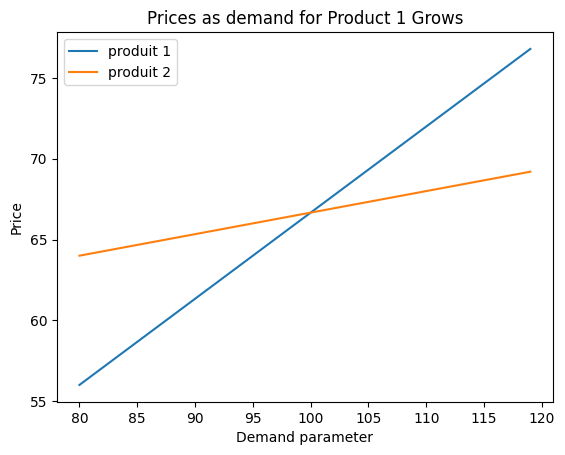

In [ ]:
import matplotlib.pyplot as plt

def fonction_p1(a1):
  return 1/1.875*(a1+25)

def fonction_p2(a1):
  return 1/1.875*(a1*0.25+100)

valeurs_a1 = [i for i in range(80, 120)]

resultats_p1 = []
resultats_p2 = []

for valeur in valeurs_a1:
    resultat = fonction_p1(valeur)
    resultats_p1.append(resultat)

for valeur in valeurs_a1:
    resultat = fonction_p2(valeur)
    resultats_p2.append(resultat)

# Tracer le graphique
plt.plot(valeurs_a1, resultats_p1, label='produit 1')
plt.plot(valeurs_a1, resultats_p2, label='produit 2')

# Ajouter des étiquettes
plt.title('Prices as demand for Product 1 Grows')
plt.xlabel('Demand parameter')
plt.ylabel('Price')
plt.legend()

Text(0, 0.5, 'MHHID')

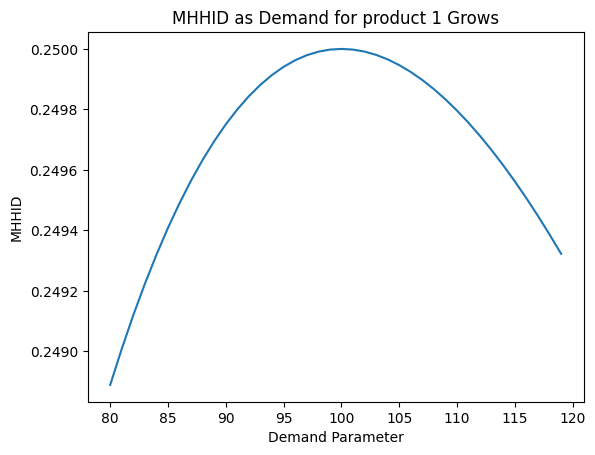

In [ ]:
def fonction_q1(a1, p1, p2):
  return a1-p1+0.5*p2

def fonction_q2(p1, p2):
  return 100-p2+0.5*p1

resultats_q1 = []
resultats_q2 = []

for a1, p1, p2 in zip(valeurs_a1, resultats_p1, resultats_p2):
  resultat = fonction_q1(a1, p1, p2)
  resultats_q1.append(resultat)

for p1, p2 in zip(resultats_p1, resultats_p2):
  resultat = fonction_q2(p1, p2)
  resultats_q2.append(resultat)

MHHID = []
def fonction_MHHID(q1, q2):
  return (q1/(q1+q2))*(q2/(q1+q2))

for q1, q2 in zip(resultats_q1, resultats_q2):
  resultat = fonction_MHHID(q1, q2)
  MHHID.append(resultat)

plt.plot(valeurs_a1, MHHID)

# Ajouter des étiquettes
plt.title('MHHID as Demand for product 1 Grows')
plt.xlabel('Demand Parameter')
plt.ylabel('MHHID')

####**Question d)**

Les histogrammes jaunes et verts représentent des données de panel. Une utilisation de chacune d'elle entraîne des résultats sur le prix optimal et sur le MHHID.

Si les données sont représentées par l'histogramme en vert, l'on observe que le MHHID augmente avec l'augmentation des prix des firmes 1 et 2 (corrélation positive) dont un investisseur détient 20% de chacune. Une augmentation du MHHID, toute chose égale par ailleurs, signifie une plus grand concentration du marché. Ainsi, les profits augmentent résultant en des dividendes plus élevées pour l'investisseur.

Cependant avec les données représentées par l'histogramme en jaune, une augmentation des prix des firmes 1 et 2 fait diminuer le MHHID. On observe donc moins de concentration de marché. Ceci pourrait signifier moins de profits et donc moins de dividendes reversées à l'investisseur.

Considérant que le MHHID est composé de kappa et de s, il serait possible de supposer que lorsque la collusion augmente, le prix des produits augmente tandis que la quantité vendue diminue pour maximiser les profits. Lorsque la diminution de la part de marché change moins vite que l'augmentation de kappa, le MHHID augmente. Il est donc possible de considérer que l'évolution progressive de la collusion permet un déplacement de la droite de la courbe vers le point optimal du MHHID. Lorsque la diminution de la part de marché change plus vite que l'augmentation de kappa, le MHHID diminue. Il est donc possible de considérer que l'évolution progressive de la collusion permet un déplacement du point optimal du MHHID vers la gauche de la courbe.

Ainsi, un investisseur commun maximiserait ses dividendes à l'intersection des courbes de demandes des firmes 1 et 2, soit lorsque le MHHID atteint son maximum.

### 5. Cournot Game


In [ ]:
# SIMULATE COURNOT GAME

from scipy import optimize, array
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


# P = A - q1 - q2
def price(q1, q2, A):
    return A - q1 - q2

# CONSTANT MARGINAL COST
def cost(q, c):
    if q <= 0:
        cost = 0
    else:
        cost = c * q
    return cost


# PROFITS
def tprofit(q1, q2, k, A, c):
    return price(q1, q2, A) * q1 - cost(q1, c) + k*(price(q1, q2, A) * q2 - cost(q2, c))

# FIND OPTIMAL QUANTITY
def reaction(q2, k, A, c):
    q1 = optimize.brute(lambda q: -tprofit(q, q2, k, A, c), [[0, 1]]) # brute minimizes the function;
                                                               # when we minimize -profits, we maximize profits
    return q1[0]

# STACK THE TWO REACTION FUNCTIONS IN THE FORM q1 = q1(q2) AND q2 = q2(q1)
#np.array permet de créer un vecteur.
def vector_reaction(q, k, A, c1, c2): # vector param = (A, c1, c2)
    return array(q) - array([reaction(q[1], k, A, c1), reaction(q[0], k, A, c2)])

# COURNOT EQUILIBRIUM

A = 1.2
c1 = c2 = c = 0.1
k=1

# INITIAL GUESS
q0 = [0.2, 0.2]

q_eqm = optimize.fsolve(vector_reaction, q0, args = (k, A, c1, c2))
q_total = 0.0
for element in q_eqm:
     q_total += element

profits_total = tprofit(q_eqm[0], q_eqm[1], k, A, c)

def profit1(q1, q2,A, c1):
    return price(q1, q2, A) * q1 - cost(q1, c1)

def profit2(q1, q2, A, c2):
    return price(q1, q2, A) * q2 - cost(q2, c2)

profits_eqm = [profit1(q_eqm[0], q_eqm[1], A, c1), profit2(q_eqm[0], q_eqm[1], A, c2)]

print("Each firm quantities", q_eqm)
print("Total quantities", q_total)
print("Total profits", profits_total)
print("Each firm profits", profits_eqm)

<ipython-input-98-449a65a6ecd9>:36: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  return array(q) - array([reaction(q[1], k, A, c1), reaction(q[0], k, A, c2)])


Each firm quantities [0.27499486 0.27499486]
Total quantities 0.5499897230390618
Total profits 0.30249999989438403
Each firm profits [0.15124999994719612, 0.1512499999471879]


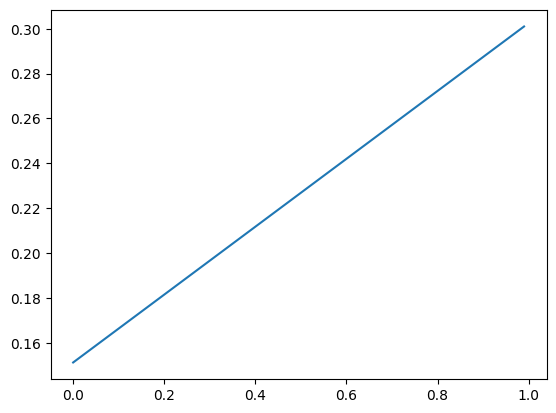

In [ ]:
range_k = np.arange(0, 1, 0.01)  # ARANGE(INITIAL, FINAL, STEP)
range_R = [tprofit(q_eqm[0], q_eqm[1], k, A, c) for k in range_k]

plt.plot(range_k, range_R,)

**Interprétation**
$$$$
Ainsi plus le kappa est élevé, plus la valeur de profit cumulé des deux firmes est élevé (pente positive). Avec kappa = 1, nous obtenons les résultats pour le cas de la collusion parfaite (monopoleur). En effet, le paramètre kappa représente le degré de collusion entre les deux entreprises. Avec kappa = 1, elles agissent comme un seul acteur sur le marché, fixant les prix et la production de manière à maximiser le profit global plutôt que de se concurrencer pour les parts de marché.
$$$$
Avec le graphique, nous pouvons observer l'évolution des profits totaux en fonction de leur degré de collusion. La valeur avec kappa = 0 représentant leurs profits conjoints en l'absence de collusion. Dans notre cas, une collusion parfaite par rapport à l'absence totale de collusion permet de quasiment doubler le profit conjoint.

### 6. Coffee regressions

In [ ]:
coffee = pd.read_csv('coffee_data.csv')

coffee['q_world_jandec'] = coffee['q_world_jandec'] / 1000

coffee['q_cartel_jandec'] = coffee['q_cartel_jandec'] / 1000

coffee['q_viet_jandec'] = coffee['q_viet_jandec'] / 1000

coffee['constant'] = 1
coffee['date'] = pd.to_datetime(coffee['calendar_year'].astype(str) + '-' + coffee['calendar_month'].astype(str) + '-01', format='%Y-%m-%d')
last_column = coffee.pop(coffee.columns[-1])  # Remove the last column and store it
coffee.insert(0, last_column.name, last_column)

coffee.head()

,date,calendar_year,calendar_month,coffee_p_real,tea_p_real,q_world_jandec,q_cartel_jandec,q_viet_jandec,log_richgdp_jandec,farm_p_real_jandec,frost01,frost02,frost03,constant
0,1960-01-01,1960,1,257.59,984.42,3.558833,3.5555,0.003333,-0.711407,NaN,0,0,0,1
1,1960-02-01,1960,2,262.63,953.07,3.558833,3.5555,0.003333,-0.711407,NaN,0,0,0,1
2,1960-03-01,1960,3,259.81,903.35,3.558833,3.5555,0.003333,-0.711407,NaN,0,0,0,1
3,1960-04-01,1960,4,258.65,875.48,3.558833,3.5555,0.003333,-0.711407,NaN,0,0,0,1
4,1960-05-01,1960,5,265.40,889.46,3.558833,3.5555,0.003333,-0.711407,NaN,0,0,0,1


#### **(a) estimate regression with different types of control variables**

##### **i. nothing included in X**



In [ ]:
from linearmodels import OLS

# Define the dependent variable (endogenous variable) and the independent variable (exogenous variable)
dependent_variable = 'coffee_p_real'
independent_variable = 'q_world_jandec'
control_variables = 'constant'

# Create the OLS model
model = OLS(coffee[dependent_variable], coffee[[independent_variable, control_variables]])

# Fit the model
result = model.fit()
coefficients_df = pd.DataFrame(columns=['Model', 'Variable', 'Coefficient'])
coefficients_df = coefficients_df.append({'Model': f'Model {1}',
                                          'Variable': independent_variable,
                                          'Coefficient': result.params[independent_variable]}, ignore_index=True)

# Print regression results
print(result)


                            OLS Estimation Summary                            
Dep. Variable:          coffee_p_real   R-squared:                      0.3590
Estimator:                        OLS   Adj. R-squared:                 0.3579
No. Observations:                 576   F-statistic:                    312.29
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:02   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
q_world_jandec    -75.552     4.2753    -17.672     0.0000     -83.932     -67.173
constant           655.65     27.189

<ipython-input-101-5e7bb4a85f32>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Model': f'Model {1}',


##### **ii. include GDP as control variable**

In [ ]:
# Define the dependent variable (endogenous variable) and the independent variable (exogenous variable)
dependent_variable = 'coffee_p_real'
independent_variable = 'q_world_jandec'
independent_variable2 = 'log_richgdp_jandec'
control_variables = 'constant'

# Create the OLS model
model = OLS(coffee[dependent_variable], coffee[[independent_variable, independent_variable2, control_variables]])


# Fit the model
result = model.fit()

# Print regression results
print(result)
coefficients_df = coefficients_df.append({'Model': f'Model {2}',
                                          'Variable': independent_variable,
                                          'Coefficient': result.params[independent_variable]}, ignore_index=True)

coefficients_df = coefficients_df.append({'Model': f'Model {2}',
                                              'Variable': independent_variable2,
                                              'Coefficient': result.params[independent_variable2]}, ignore_index=True)

                            OLS Estimation Summary                            
Dep. Variable:          coffee_p_real   R-squared:                      0.4996
Estimator:                        OLS   Adj. R-squared:                 0.4978
No. Observations:                 576   F-statistic:                    575.76
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:02   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
q_world_jandec        -200.59     18.321    -10.949     0.0000     -236.49     -164.68
log_richgdp_jandec  

<ipython-input-102-6e952eed49f6>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Model': f'Model {2}',
<ipython-input-102-6e952eed49f6>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Model': f'Model {2}',


##### **iii. include GDP and tea price as control variables**

In [ ]:
dependent_variable = 'coffee_p_real'
independent_variable = 'q_world_jandec'
independent_variable2 = 'log_richgdp_jandec'
independent_variable3 = 'tea_p_real'
control_variables = 'constant'

# Create the OLS model
model = OLS(coffee[dependent_variable], coffee[[independent_variable, independent_variable2, independent_variable3,control_variables]])

# Fit the model
result = model.fit()
coefficients_df = coefficients_df.append({'Model': f'Model {3}',
                                          'Variable': independent_variable,
                                          'Coefficient': result.params[independent_variable]}, ignore_index=True)
coefficients_df = coefficients_df.append({'Model': f'Model {3}',
                                              'Variable': independent_variable2,
                                              'Coefficient': result.params[independent_variable2]}, ignore_index=True)
coefficients_df = coefficients_df.append({'Model': f'Model {3}',
                                              'Variable': independent_variable3,
                                              'Coefficient': result.params[independent_variable3]}, ignore_index=True)
# Print regression results
print(result)

                            OLS Estimation Summary                            
Dep. Variable:          coffee_p_real   R-squared:                      0.6686
Estimator:                        OLS   Adj. R-squared:                 0.6669
No. Observations:                 576   F-statistic:                    802.73
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:02   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
q_world_jandec        -194.42     10.679    -18.205     0.0000     -215.35     -173.49
log_richgdp_jandec  

<ipython-input-103-96187167ea97>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Model': f'Model {3}',
<ipython-input-103-96187167ea97>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Model': f'Model {3}',
<ipython-input-103-96187167ea97>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df = coefficients_df.append({'Model': f'Model {3}',


##### **iv. discutez des coeff**

Dans (i), le signe de la quantité est cohérent dans la régression avec la théorie économique : une augmentation de la quantité réduit le prix du café de 75$. De plus, les résultats sont significatifs au niveau de signification 1%.

Dans (ii), le signe de la quantité est cohérent dans la régression avec la théorie économique : une augmentation de la quantité réduit le prix du café de 201\$. De plus, les résultats sont significatifs au niveau de signification 1%.
Le signe du PIB est cohérent avec la théorie économique : une augmentation du PIB augmente le prix du café de 357$. De plus, les résultats sont significatifs au niveau de signification 1%.

Dans (iii), le signe de la quantité est cohérent dans la régression avec la théorie économique: une augmentation de la quantité réduit le prix du café de 194\$.De plus, les résultats sont significatifs au niveau de signification 1%.
Le signe du PIB est cohérent dans la régression avec la théorie économique : une augmentation du PIB augmente le prix du café de 617\$. De plus, les résultats sont significatifs au niveau de signification 1%.
Le signe du thé est cohérent dans la régression avec la théorie économique : une augmentation du thé augmente le prix du café de 0.55$. Ce résultat s'explique par le fait que le thé peut être considéré comme un substitut du café. L'idée derrière est que l'augmentation du prix du thé entraîne une diminution de la quantité vendu de thé, une augmentation de la quantité vendu de café, et donc une augmentation du prix de café. De plus, les résultats sont significatifs au niveau de signification 1%.

Tous les signes ont donc une interprétation économique cohérente.

In [ ]:
print(coefficients_df)

     Model            Variable  Coefficient
0  Model 1      q_world_jandec   -75.552452
1  Model 2      q_world_jandec  -200.585192
2  Model 2  log_richgdp_jandec   357.234510
3  Model 3      q_world_jandec  -194.418237
4  Model 3  log_richgdp_jandec   616.610824
5  Model 3          tea_p_real     0.548376


#### **(b) Utiliser les chocs météorologiques (colonnes frost01, frost02, frost03) comme instruments pour la variable Qworld**

##### **i. nothing for X**

In [ ]:
for col in ['frost01', 'frost02', 'frost03']:
    coffee[col] = pd.Categorical(coffee[col])

In [ ]:
from linearmodels import IV2SLS
# Define the dependent variable, independent variable, and instrumental variables
dependent_variable = 'coffee_p_real'
independent_variable = 'q_world_jandec'
control_variables = 'constant'

# Créer les variables indicatrices
coffee = pd.get_dummies(coffee, drop_first=True)

instrumental_variables = [col for col in coffee.columns if col.startswith('frost01_') or col.startswith('frost02_') or col.startswith('frost03_')]

# Create the IV2SLS model
model = IV2SLS(dependent=coffee[dependent_variable],
               exog=coffee[control_variables],
               endog=coffee[independent_variable],  # The endogenous variable
               instruments=coffee[instrumental_variables])

# Fit the model
result = model.fit()
coefficients_df2 = pd.DataFrame(columns=['Model', 'Variable', 'Coefficient'])
coefficients_df2 = coefficients_df2.append({'Model': f'Model {1}',
                                          'Variable': independent_variable,
                                          'Coefficient': result.params[independent_variable]}, ignore_index=True)
# Print regression results
print(result)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          coffee_p_real   R-squared:                     -2.3760
Estimator:                    IV-2SLS   Adj. R-squared:                -2.3818
No. Observations:                 576   F-statistic:                    99.805
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:02   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
constant           1796.7     153.71     11.689     0.0000      1495.4      2097.9
q_world_jandec    -284.07     28.435

<ipython-input-106-da0fdd19ea5c>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df2 = coefficients_df2.append({'Model': f'Model {1}',


##### **ii. include GDP as control variable**

In [ ]:
from linearmodels import IV2SLS
import pandas as pd

# Define the dependent variable, independent variable, control variable, and instrumental variables
dependent_variable = 'coffee_p_real'
independent_variable = 'q_world_jandec'
independent_variable2 = 'log_richgdp_jandec'
control_variables = 'constant'

instrumental_variables = [col for col in coffee.columns if col.startswith('frost01_') or col.startswith('frost02_') or col.startswith('frost03_')]

# Create the IV2SLS model
model = IV2SLS(dependent=coffee[dependent_variable],
               exog=coffee[[independent_variable2, control_variables]],  # Control variable
               endog=coffee[independent_variable],  # The endogenous variable
               instruments=coffee[instrumental_variables])

# Fit the model
result = model.fit()

# Print regression results
print(result)
coefficients_df2 = coefficients_df2.append({'Model': f'Model {2}',
                                          'Variable': independent_variable,
                                          'Coefficient': result.params[independent_variable]}, ignore_index=True)
coefficients_df2 = coefficients_df2.append({'Model': f'Model {2}',
                                              'Variable': independent_variable2,
                                              'Coefficient': result.params[independent_variable2]}, ignore_index=True)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          coffee_p_real   R-squared:                      0.3685
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3663
No. Observations:                 576   F-statistic:                    346.65
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:02   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
log_richgdp_jandec     679.93     72.329     9.4005     0.0000      538.17      821.70
constant            

<ipython-input-107-02328d659afb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df2 = coefficients_df2.append({'Model': f'Model {2}',
<ipython-input-107-02328d659afb>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df2 = coefficients_df2.append({'Model': f'Model {2}',


##### **iii. include GDP and tea price as control variables**

In [ ]:
from linearmodels import IV2SLS

# Define the dependent variable, independent variable, control variable, and instrumental variables
dependent_variable = 'coffee_p_real'
independent_variable = 'q_world_jandec'
independent_variable2 = 'log_richgdp_jandec'
independent_variable3 = 'tea_p_real'
control_variables = 'constant'

instrumental_variables = [col for col in coffee.columns if col.startswith('frost01_') or col.startswith('frost02_') or col.startswith('frost03_')]

# Create the IV2SLS model
model = IV2SLS(dependent=coffee[dependent_variable],
               exog=coffee[[control_variables, independent_variable2, independent_variable3]],  # Control variable
               endog=coffee[independent_variable],  # The endogenous variable
               instruments=coffee[instrumental_variables])

# Fit the model
result = model.fit()
coefficients_df2 = coefficients_df2.append({'Model': f'Model {3}',
                                          'Variable': independent_variable,
                                          'Coefficient': result.params[independent_variable]}, ignore_index=True)
coefficients_df2 = coefficients_df2.append({'Model': f'Model {3}',
                                              'Variable': independent_variable2,
                                              'Coefficient': result.params[independent_variable2]}, ignore_index=True)
coefficients_df2 = coefficients_df2.append({'Model': f'Model {3}',
                                              'Variable': independent_variable3,
                                              'Coefficient': result.params[independent_variable3]}, ignore_index=True)
# Print regression results
print(result)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          coffee_p_real   R-squared:                      0.5927
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5906
No. Observations:                 576   F-statistic:                    806.69
Date:                Fri, Feb 16 2024   P-value (F-stat)                0.0000
Time:                        19:44:02   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
constant               1421.6     81.880     17.362     0.0000      1261.1      1582.1
log_richgdp_jandec  

<ipython-input-108-69ba38089cd7>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df2 = coefficients_df2.append({'Model': f'Model {3}',
<ipython-input-108-69ba38089cd7>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df2 = coefficients_df2.append({'Model': f'Model {3}',
<ipython-input-108-69ba38089cd7>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefficients_df2 = coefficients_df2.append({'Model': f'Model {3}',


In [ ]:
print(coefficients_df2)

     Model            Variable  Coefficient
0  Model 1      q_world_jandec  -284.074060
1  Model 2      q_world_jandec  -329.669169
2  Model 2  log_richgdp_jandec   679.933054
3  Model 3      q_world_jandec  -292.746162
4  Model 3  log_richgdp_jandec   854.684561
5  Model 3          tea_p_real     0.532935


Dans (i), le signe de la quantité est cohérent dans la régression avec la théorie économique : une augmentation de la quantité réduit le prix du café de 338$. De plus, les résultats sont significatifs au niveau de signification 1%.

Dans (ii), le signe de la quantité est cohérent dans la régression avec la théorie économique : une augmentation de la quantité réduit le prix du café de 392\$. De plus, les résultats sont significatifs au niveau de signification 1%. Le signe du PIB est cohérent avec la théorie économique : une augmentation du PIB augmente le prix du café de 835$. De plus, les résultats sont significatifs au niveau de signification 1%.

Dans (iii), le signe de la quantité est cohérent dans la régression avec la théorie économique: une augmentation de la quantité réduit le prix du café de 328\$. De plus, les résultats sont significatifs au niveau de signification 1%. Le signe du PIB est cohérent dans la régression avec la théorie économique : une augmentation du PIB augmente le prix du café de 940\$. De plus, les résultats sont significatifs au niveau de signification 1%. Le signe du thé est cohérent dans la régression avec la théorie économique : une augmentation du thé augmente le prix du café de 0.53$. Ce résultat s'explique par le fait que le thé peut être considéré comme un substitut du café. L'idée derrière est que l'augmentation du prix du thé entraîne une diminution de la quantité vendu de thé, une augmentation de la quantité vendu de café, et donc une augmentation du prix de café. De plus, les résultats sont significatifs au niveau de signification 1%.

Tous les signes ont donc une interprétation économique cohérente, tout comme les résultats naïfs.

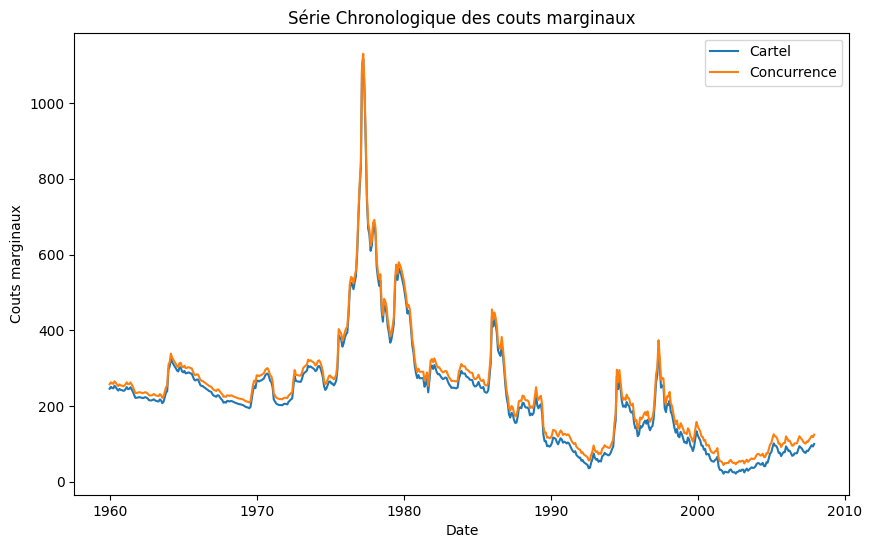

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Définition des valeurs pour N_concurrence et N_cartel
N_concurrence = 55
N_cartel = 1

# Calcul de mc_concurrence et mc_cartel
coffee['mc_concurrence'] = coffee['coffee_p_real'] + coffee['q_world_jandec']*1000/(-292.7*N_concurrence)
coffee['mc_cartel'] = coffee['coffee_p_real'] + coffee['q_world_jandec']*1000/(-292.7*N_cartel)

# Création de la variable date
coffee['date'] = pd.to_datetime(coffee['calendar_year'].astype(str) + coffee['calendar_month'].astype(str), format='%Y%m')
coffee.set_index('date', inplace=True)

# Tracé de la série chronologique
plt.figure(figsize=(10, 6))
plt.plot(coffee.index, coffee['mc_cartel'], label='Cartel')
plt.plot(coffee.index, coffee['mc_concurrence'], label='Concurrence')
plt.title('Série Chronologique des couts marginaux')
plt.xlabel('Date')
plt.ylabel('Couts marginaux')
plt.legend()
plt.show()



Il est possible d'observer que les coûts marginaux sont plus faibles en la présence d'un cartel que dans le modèle de concurrence. Ces résultats pourraient être expliqués par la théorie économique. En effet, si l'on considère que les coûts marginaux sont croissants avec l'augmentation de la quantité, alors la production d'une quantité plus faible qu'à l'équilibre génère un coût marginal plus faible.